# Comparison of GraphSage Derived Topological Embeddings

Lee Lancashire

Every Cure

16 August 2024. 

## Introduction

This notebook compares topological embeddings from two different sources:
1. Embeddings from an end-to-end (e2e) run
2. Embeddings from Chunyu's work

The analysis includes data loading, preprocessing, dimensionality reduction, visualization, and comparison of the embeddings.

Note: Your project should be organized as follows:

```
project_root/
│
├── data/
│   ├── raw/                 # Raw data files; TP, TN, Embeddings etc..
│   ├── processed/           # Processed data files produced by this notebook
│
├── notebooks/
│   └── 05_evaluate.ipynb    # This notebook
│
├── results/
│   ├── figures/             # Generated figures
│   └── models/              # Saved models
```

## Data Loading and Preprocessing

### Loading e2e Embeddings

The e2e embeddings are loaded from Parquet files stored in Google Cloud Storage.

In [25]:
# Not run
# 
# import gcsfs

# file_path = "gs://mtrx-us-central1-hub-dev-storage/releases/20240807/04_feature/rtx_kg2_nodes"

# fs = gcsfs.GCSFileSystem(project='mtrx-us-central1-hub-dev-storage')
# with fs.open(file_path, 'rb') as file:
#    obj = pd.read_parquet(file)

### Downloading Data

All files need to be downloaded using gsutil from the Google Cloud Storage bucket [eg here](https://console.cloud.google.com/storage/browser/mtrx-us-central1-hub-dev-storage/releases/20240807/05_model_input/drugs_diseases_nodes;tab=objects?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&project=mtrx-hub-dev-3of&prefix=&forceOnObjectsSortingFiltering=false&chat=true). The following command can be used to copy all data:

```bash
gsutil -m cp \
  "gs://mtrx-us-central1-hub-dev-storage/releases/20240807/05_model_input/drugs_diseases_nodes/* " .
  ```

### Importing Required Libraries

We import the necessary libraries for data manipulation, visualization, and machine learning tasks.

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import os



## Data Loading and Preprocessing

### Loading e2e Embeddings

The e2e embeddings are loaded from Parquet files stored in Google Cloud Storage.

In [27]:

# Define the directory where Parquet files are stored
directory_path = '../data/raw/05_embeddings_data/'

# List all Parquet files in the directory
parquet_files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]


# Read each Parquet file into a DataFrame and concatenate them into one DataFrame
df = pd.concat([pd.read_parquet(os.path.join(directory_path, file)) for file in parquet_files], ignore_index=True)

### Processing e2e Embeddings

We process the loaded data and save it to a new Parquet file for easier access in future analyses.

In [28]:
# Path to the embeddings file
parquet_path = '../data/processed/topological_embeddings.parquet'

# Check if the file exists
if os.path.exists(parquet_path):
    # Load the DataFrame from the Parquet file
    final_df = pd.read_parquet(parquet_path)
else:
    # Convert the list of embeddings directly into a DataFrame
    embedding_df = pd.DataFrame(df['topological_embedding'].tolist())

    # Rename the columns to TE1, TE2, etc.
    embedding_df.columns = [f'TE{i+1}' for i in range(embedding_df.shape[1])]

    # Join the new columns back to the original DataFrame with the additional columns
    final_df = df[['id', 'name', 'category']].join(embedding_df)

    # Save the DataFrame to a CSV file
    final_df.to_csv('topological_embeddings.csv', index=False)

    # Save the DataFrame to a Parquet file
    final_df.to_parquet(parquet_path)

# Display the first few rows of the DataFrame to verify
final_df


id  \
0             UMLS:C0775908   
1             UMLS:C0775076   
2             UMLS:C4237687   
3       REACT:R-ALL-9731197   
4             UMLS:C0256140   
...                     ...   
399832        UMLS:C4024822   
399833        UMLS:C1880518   
399834        UMLS:C1834034   
399835        UMLS:C3554587   
399836        UMLS:C4476563   

                                                     name  \
0                                      Asafetida Tincture   
1                                     Hydroquinone Powder   
2                            Bromfenac Sodium Bulk powder   
3                                   PF-00835231 [cytosol]   
4                                            neocnidilide   
...                                                   ...   
399832                             Lacrimal gland aplasia   
399833                Environmental Compatibility Problem   
399834  Aplasia/Hypoplasia of the middle phalanx of th...   
399835                       Telangiectases of the cheeks   
399836                     Enlarged mesenteric lymph node   

                                  category           TE1           TE2  \
0                             biolink:Drug  2.762366e-32  2.588563e-66   
1                             biolink:Drug  1.761803e-25  6.262243e-02   
2                             biolink:Drug  1.670094e-27  7.164594e-02   
3                             biolink:Drug  1.383146e-19  7.043168e-02   
4                             biolink:Drug  1.449573e-28  7.372893e-41   
...                                    ...           ...           ...   
399832  biolink:DiseaseOrPhenotypicFeature  1.203380e-18  6.262243e-02   
399833  biolink:DiseaseOrPhenotypicFeature  1.583526e-27  1.367426e-55   
399834  biolink:DiseaseOrPhenotypicFeature  5.490582e-25  1.288037e-36   
399835  biolink:DiseaseOrPhenotypicFeature  5.364115e-24  7.326023e-20   
399836  biolink:DiseaseOrPhenotypicFeature  2.825277e-20  6.262243e-02   

                 TE3           TE4           TE5           TE6           TE7  \
0       8.819362e-30  1.226528e-65  4.334934e-61  1.226693e-11  5.382879e-20   
1       7.649446e-28  6.262243e-02  6.262243e-02  1.716841e-11  2.360101e-21   
2       5.409929e-29  7.120692e-02  7.163979e-02  1.115442e-11  1.120049e-21   
3       2.006351e-20  7.037671e-02  7.043116e-02  1.610154e-08  2.216364e-15   
4       4.886710e-27  6.380856e-42  6.831340e-38  1.355204e-10  7.351284e-19   
...              ...           ...           ...           ...           ...   
399832  3.971628e-20  6.262243e-02  6.262243e-02  1.695704e-08  1.853991e-15   
399833  4.330004e-25  1.538767e-56  9.810606e-52  6.514698e-10  7.785165e-17   
399834  6.409441e-24  5.175219e-39  2.441232e-35  1.072215e-09  1.258320e-16   
399835  1.241787e-23  4.351994e-22  5.587203e-19  1.346464e-09  7.827482e-17   
399836  1.088757e-23  6.262243e-02  6.262243e-02  4.830590e-10  5.957888e-19   

        ...     TE503     TE504         TE505         TE506         TE507  \
0       ...  0.069010  0.069010  7.364172e-79  1.450837e-18  1.845099e-33   
1       ...  0.062622  0.062622  6.262243e-02  8.879277e-13  1.832034e-24   
2       ...  0.071646  0.071646  5.044239e-02  2.843080e-14  6.793688e-27   
3       ...  0.070432  0.070432  6.931194e-02  1.968364e-10  3.471745e-19   
4       ...  0.069172  0.069172  3.545905e-51  3.691001e-16  2.997572e-29   
...     ...       ...       ...           ...           ...           ...   
399832  ...  0.062622  0.062622  6.262243e-02  1.262952e-09  6.671522e-18   
399833  ...  0.069007  0.069007  3.008957e-67  4.096610e-16  1.154802e-28   
399834  ...  0.069171  0.069171  3.376812e-45  3.427774e-14  1.490267e-25   
399835  ...  0.075462  0.075462  2.088781e-27  3.228181e-13  3.846840e-24   
399836  ...  0.062622  0.062622  6.262243e-02  1.554450e-09  1.078519e-18   

               TE508     TE509     TE510     TE511         TE512  
0       5.642932e-33  0.069010  0.069010  0.069010  8.042107e-71  
1       1.

### Subsampling the Dataset

To manage computational resources, we subsample 30% of the data, stratified by category.

In [29]:
# Group by 'category' and sample 30% from each group

frac = 0.1

def load_or_generate_subsampled_df(final_df, frac=frac, random_state=42):
    csv_path = '../data/processed/subsampled_df.csv'
    parquet_path = '../data/processed/subsampled_df.parquet'
    
    # Check if the files exist
    if os.path.exists(csv_path) and os.path.exists(parquet_path):
        print("Loading existing subsampled DataFrame...")
        subsampled_df = pd.read_parquet(parquet_path)
    else:
        print("Generating new subsampled DataFrame...")
        # Group by 'category' and sample 30% from each group
        subsampled_df = final_df.groupby('category').apply(lambda x: x.sample(frac=frac, random_state=random_state)).reset_index(drop=True)
        
        # Save the subsampled DataFrame
        subsampled_df.to_csv(csv_path, index=False)
        subsampled_df.to_parquet(parquet_path, index=False)
    
    print("Original DataFrame size:", final_df.shape[0])
    print("Subsampled DataFrame size:", subsampled_df.shape[0])
    
    # Display category distributions
    print("\nOriginal category distribution:")
    print(final_df['category'].value_counts())
    print("\nSubsampled category distribution:")
    print(subsampled_df['category'].value_counts())
    
    return subsampled_df

# Use the function
subsampled_df = load_or_generate_subsampled_df(final_df)

Generating new subsampled DataFrame...


/var/folders/q6/8yx6d6r52vg4j8gy_hv63whw0000gp/T/ipykernel_49057/1406382630.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_df = final_df.groupby('category').apply(lambda x: x.sample(frac=frac, random_state=random_state)).reset_index(drop=True)


Original DataFrame size: 399837
Subsampled DataFrame size: 39983

Original category distribution:
category
biolink:SmallMolecule                 142112
biolink:Drug                          132977
biolink:Disease                        85423
biolink:DiseaseOrPhenotypicFeature     34413
biolink:PhenotypicFeature               4738
biolink:BehavioralFeature                174
Name: count, dtype: int64

Subsampled category distribution:
category
biolink:SmallMolecule                 14211
biolink:Drug                          13298
biolink:Disease                        8542
biolink:DiseaseOrPhenotypicFeature     3441
biolink:PhenotypicFeature               474
biolink:BehavioralFeature                17
Name: count, dtype: int64


## Dimensionality Reduction and Visualization

We apply three dimensionality reduction techniques to visualize the embeddings:
1. t-SNE (t-Distributed Stochastic Neighbor Embedding)
2. UMAP (Uniform Manifold Approximation and Projection)
3. PCA (Principal Component Analysis)

### t-SNE Visualization

In [30]:
from sklearn.manifold import TSNE
import numpy as np

def add_tsne_to_df(df, random_state=42):
    # Check if t-SNE columns already exist
    if 'tsne-2d-one' in df.columns and 'tsne-2d-two' in df.columns:
        print("t-SNE columns already exist. Skipping t-SNE computation.")
        return df

    print("Computing t-SNE...")
    
    # Extract only the TE columns for t-SNE
    te_columns = [col for col in df.columns if col.startswith('TE')]
    te_data = df[te_columns]

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_results = tsne.fit_transform(te_data)

    # Add the results back to the DataFrame
    df['tsne-2d-one'] = tsne_results[:, 0]
    df['tsne-2d-two'] = tsne_results[:, 1]

    # Save the updated DataFrame
    df.to_parquet('../data/processed/subsampled_df.parquet', index=False)
    
    print("t-SNE computation completed and results saved.")
    return df


subsampled_df = add_tsne_to_df(subsampled_df)



Computing t-SNE...
t-SNE computation completed and results saved.


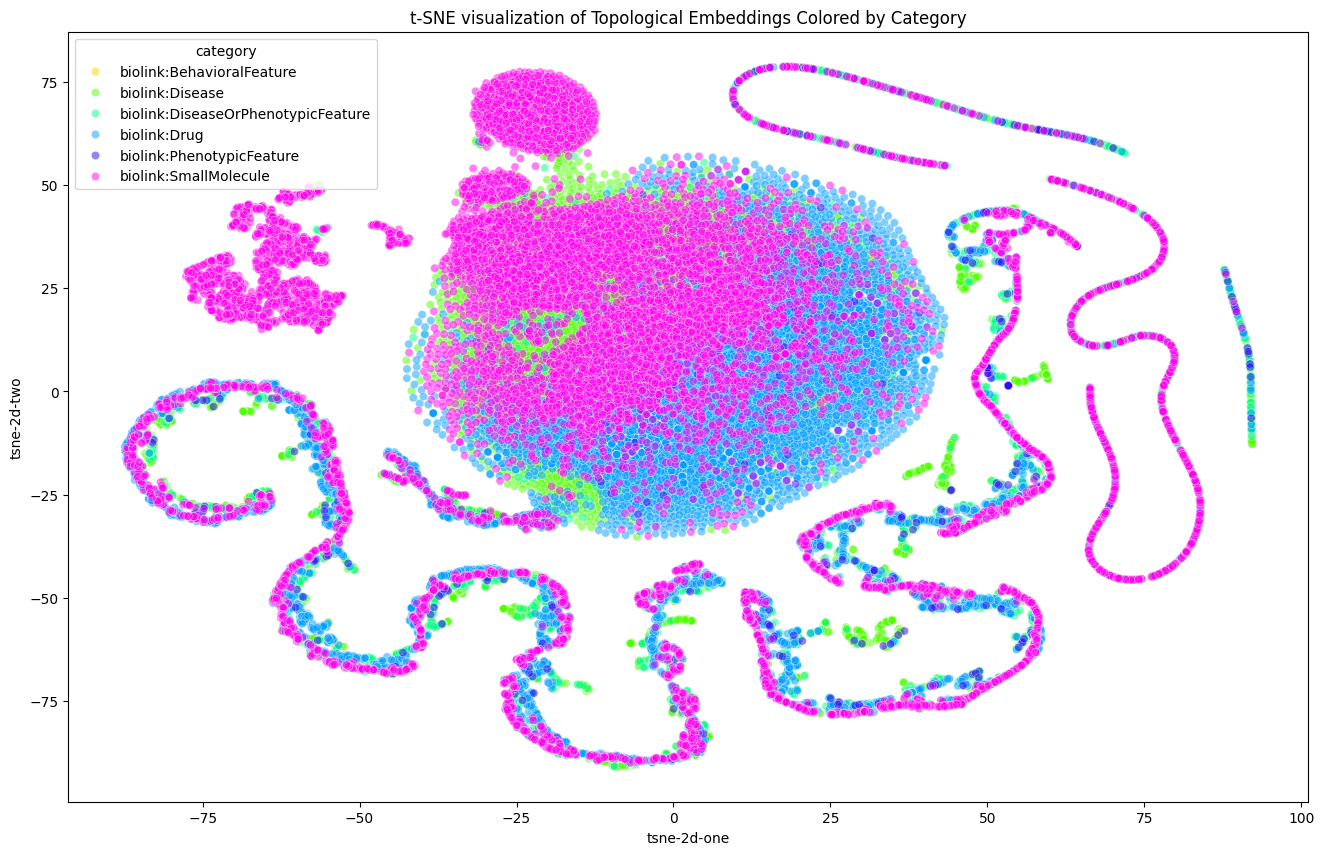

In [31]:
# Plot the result of t-SNE
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(subsampled_df['category'].unique())),
    data=subsampled_df,
    legend="full",
    alpha=0.5
)
plt.title('t-SNE visualization of Topological Embeddings Colored by Category')

plt.savefig('../results/figures/tSNE_EC.png')

plt.show()
plt.close()


### UMAP Visualization

In [32]:
from umap import UMAP

def add_umap_to_df(df, random_state=42):
    # Check if UMAP columns already exist
    if 'umap-2d-one' in df.columns and 'umap-2d-two' in df.columns:
        print("UMAP columns already exist. Skipping UMAP computation.")
        return df

    print("Computing UMAP...")
    
    # Extract only the TE columns for UMAP
    te_columns = [col for col in df.columns if col.startswith('TE')]
    te_data = df[te_columns]

    # Run UMAP
    umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=random_state)
    umap_results = umap.fit_transform(te_data)

    # Add the results back to the DataFrame
    df['umap-2d-one'] = umap_results[:, 0]
    df['umap-2d-two'] = umap_results[:, 1]

    # Save the updated DataFrame
    df.to_parquet('../data/processed/subsampled_df.parquet', index=False)
    
    print("tUMAP computation completed and results saved.")
    return df


subsampled_df = add_umap_to_df(subsampled_df)




Computing UMAP...


/Users/llanc/miniconda3/envs/parquet_env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


tUMAP computation completed and results saved.


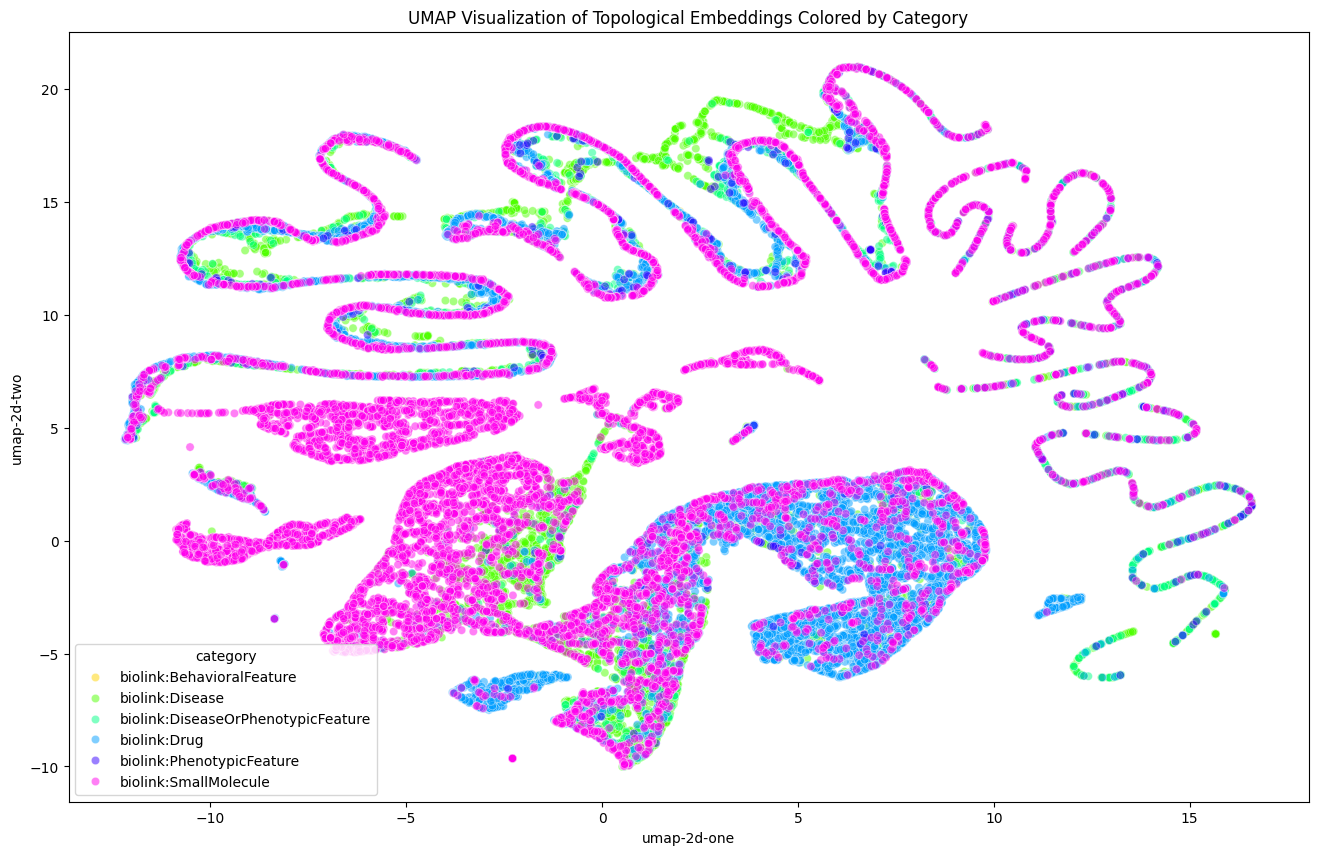

In [33]:
# Plot the result of UMAP
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="umap-2d-one", y="umap-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(subsampled_df['category'].unique())),
    data=subsampled_df,
    legend="full",
    alpha=0.5
)
plt.title('UMAP Visualization of Topological Embeddings Colored by Category')

plt.savefig('../results/figures/UMAP_EC.png')

plt.show()
plt.close()

### PCA Visualization

In [34]:
from sklearn.decomposition import PCA

def add_pca_to_df(df):
    # Check if PCA columns already exist
    if 'pca-2d-one' in df.columns and 'pca-2d-two' in df.columns:
        print("PCA columns already exist. Skipping PCA computation.")
        return df

    print("Computing PCA...")
    
    # Extract only the TE columns for PCA
    te_columns = [col for col in df.columns if col.startswith('TE')]
    te_data = df[te_columns]

    # Run PCA
    pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization
    pca_results = pca.fit_transform(te_data)

    # Add the results back to the DataFrame
    df['pca-2d-one'] = pca_results[:, 0]
    df['pca-2d-two'] = pca_results[:, 1]

    # Save the updated DataFrame
    df.to_parquet('../data/processed/subsampled_df.parquet', index=False)
    
    print("PCA computation completed and results saved.")
    return df


subsampled_df = add_pca_to_df(subsampled_df)




Computing PCA...
PCA computation completed and results saved.


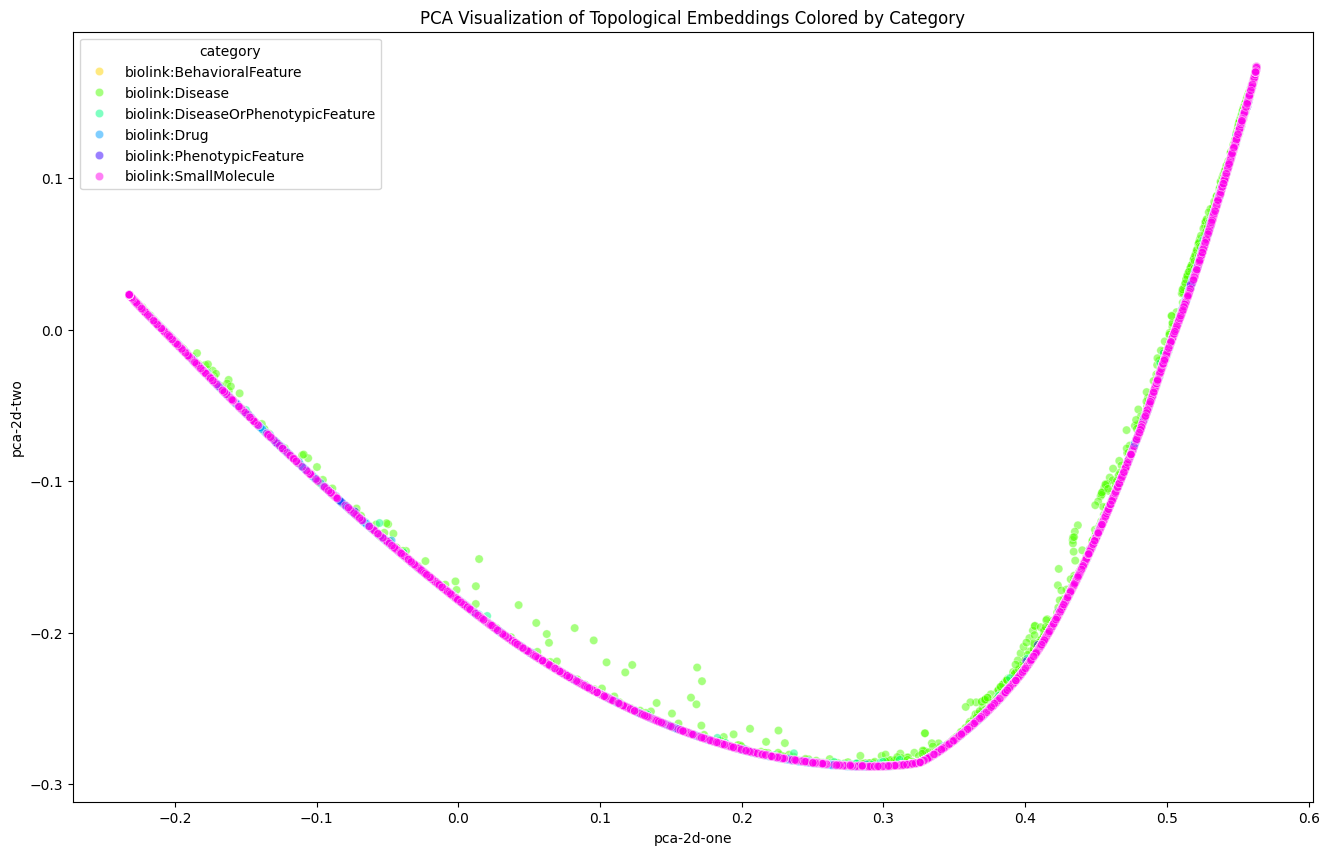

In [35]:
# Plot the result of PCA
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(subsampled_df['category'].unique())),
    data=subsampled_df,
    legend="full",
    alpha=0.5
)
plt.title('PCA Visualization of Topological Embeddings Colored by Category')
plt.savefig('../results/figures/PCA_EC.png')

plt.show()
plt.close()

## Loading and Processing Chunyu's Embeddings

We load Chunyu's embeddings from a pickle file and process them to match the structure of our e2e embeddings.

In [134]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

def process_chunyu_embeddings(pickle_path, subsampled_df, file_name='chunyu', analysis=False):
    chunyu_parquet_path = f'../data/processed/subsampled_df_{file_name}.parquet'
    
    if os.path.exists(chunyu_parquet_path):
        print(f"Loading existing {file_name} DataFrame...")
        final_df_chunyu = pd.read_parquet(chunyu_parquet_path)
    else:
        print(f"Processing {file_name} embeddings...")
        
        # Load the pickle file
        print("Loading pickle file...")
        with open(pickle_path, 'rb') as file:
            kg_dict_full = pickle.load(file)
        print("Pickle file loaded.")

        print("Subsetting data...")
        # Create a set of ids for faster lookup
        subset_ids = set(subsampled_df['id'])
        
        # Subset the dictionary
        subset_dict = {key: value for key, value in kg_dict_full.items() if key in subset_ids}

        # create dataframe
        keys = list(subset_dict.keys())
        values = np.array(list(subset_dict.values()))

        # Create DataFrame
        final_df_chunyu = pd.DataFrame(values, columns=[f'TE{i+1}' for i in range(values.shape[1])])
        final_df_chunyu['id'] = keys

        # Rearrange columns to put 'id' first
        final_df_chunyu = final_df_chunyu[['id'] + [col for col in final_df_chunyu.columns if col != 'id']]

        # add in additional information
        final_df_chunyu = final_df_chunyu.merge(subsampled_df[['id', 'name', 'category']], on='id', how='left')

        # Save the processed DataFrame
        final_df_chunyu.to_parquet(chunyu_parquet_path, index=False)
        print(f"Processed {file_name} DataFrame saved to {chunyu_parquet_path}")

    if analysis:
        analyzed_parquet_path = f'../data/processed/analyzed_df_{file_name}.parquet'
        
        if os.path.exists(analyzed_parquet_path):
            print(f"Loading existing analyzed {file_name} DataFrame...")
            final_df_chunyu = pd.read_parquet(analyzed_parquet_path)
        else:
            print("Performing dimensionality reduction...")
            # Extract only the TE columns for dimensionality reduction
            te_columns = [col for col in final_df_chunyu.columns if col.startswith('TE')]
            te_data = final_df_chunyu[te_columns]

            # Run t-SNE
            if 'tsne-2d-one' not in final_df_chunyu.columns:
                print("Running t-SNE...")
                tsne = TSNE(n_components=2, random_state=42)
                tsne_results = tsne.fit_transform(te_data)
                final_df_chunyu['tsne-2d-one'] = tsne_results[:, 0]
                final_df_chunyu['tsne-2d-two'] = tsne_results[:, 1]

            # Run UMAP
            if 'umap-2d-one' not in final_df_chunyu.columns:
                print("Running UMAP...")
                umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
                umap_results = umap.fit_transform(te_data)
                final_df_chunyu['umap-2d-one'] = umap_results[:, 0]
                final_df_chunyu['umap-2d-two'] = umap_results[:, 1]

            # Run PCA
            if 'pca-2d-one' not in final_df_chunyu.columns:
                print("Running PCA...")
                pca = PCA(n_components=2)
                pca_results = pca.fit_transform(te_data)
                final_df_chunyu['pca-2d-one'] = pca_results[:, 0]
                final_df_chunyu['pca-2d-two'] = pca_results[:, 1]
                print("Explained variance ratio:", pca.explained_variance_ratio_)

            # Save the analyzed DataFrame
            final_df_chunyu.to_parquet(analyzed_parquet_path, index=False)
            print(f"Analyzed {file_name} DataFrame saved to {analyzed_parquet_path}")

    return final_df_chunyu



In [135]:
# Create the subset dataset and perform dimensionality reduction
pickle_path = '../data/raw/unsuprvised_graphsage_entity_embeddings.pkl'
final_df_chunyu = process_chunyu_embeddings(pickle_path, subsampled_df, analysis=True)

Loading existing chunyu DataFrame...
Loading existing analyzed chunyu DataFrame...


In [136]:
# Organize all of Chunyu's data mapped to the full set of 300k embeddings for predictions later
raw_df_chunyu = process_chunyu_embeddings(pickle_path, final_df, file_name='chunyu_all', analysis=False)

Processing chunyu_all embeddings...
Loading pickle file...
Pickle file loaded.
Subsetting data...
Processed chunyu_all DataFrame saved to ../data/processed/subsampled_df_chunyu_all.parquet


## Visualizing Chunyu's Embeddings

We apply the same dimensionality reduction techniques (t-SNE, UMAP, PCA) to Chunyu's embeddings for comparison. Here we see more organization with respect to node categories being more similar in the lower dimensional space. 

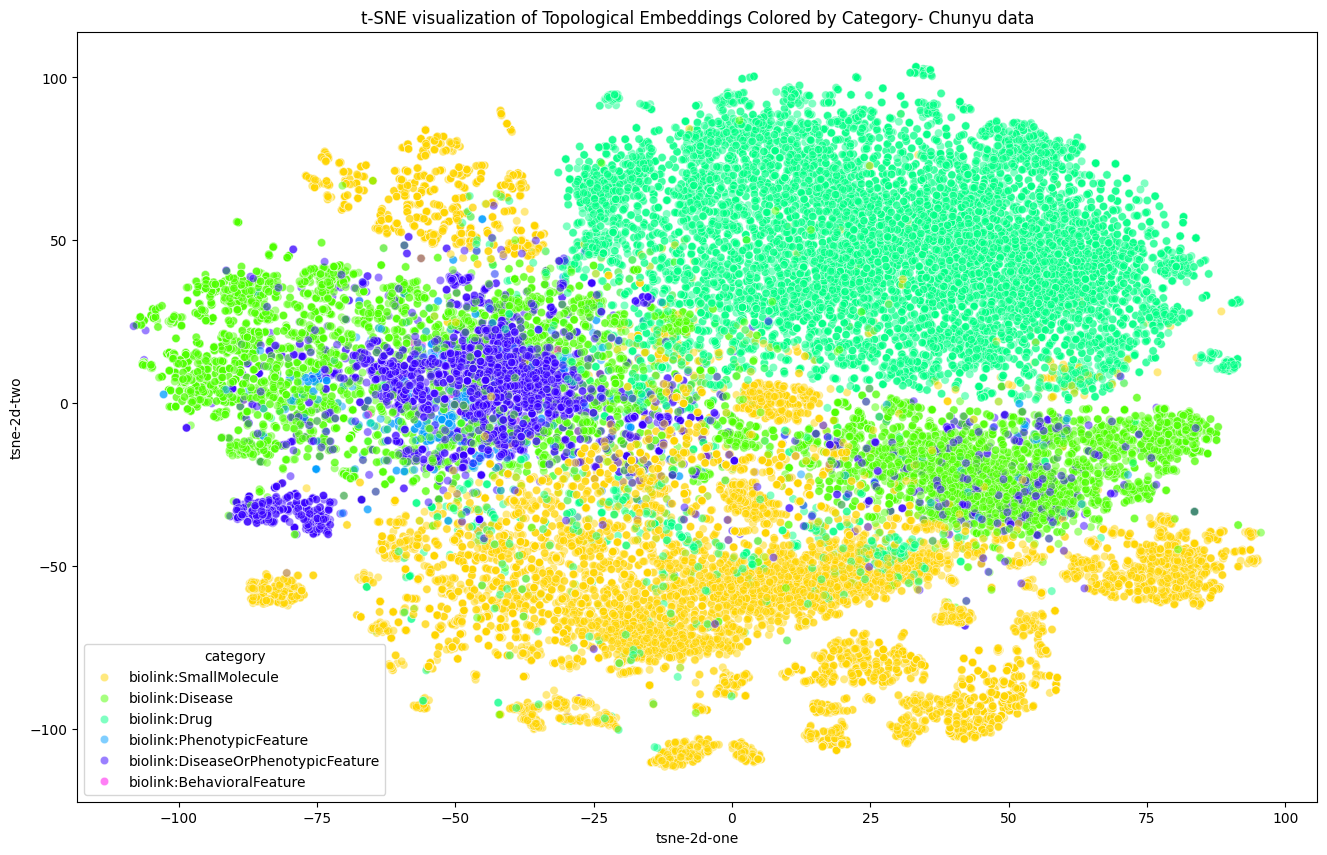

In [38]:
# Plot the result of t-SNE
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(final_df_chunyu['category'].unique())),
    data=final_df_chunyu,
    legend="full",
    alpha=0.5
)
plt.title('t-SNE visualization of Topological Embeddings Colored by Category- Chunyu data')

plt.savefig('../results/figures/tSNE_Chunyu.png')

plt.show()
plt.close()

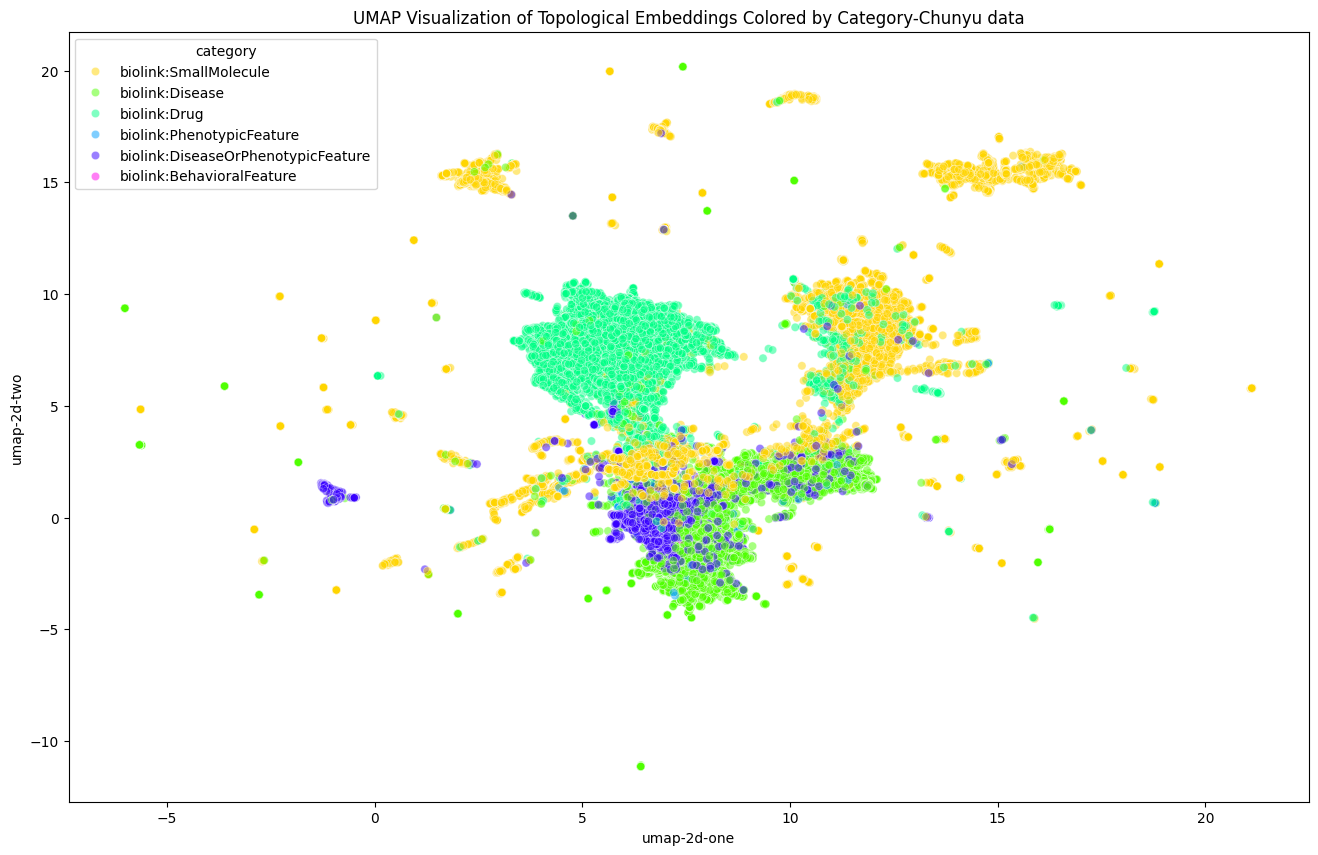

In [39]:
# Plot the result of UMAP
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="umap-2d-one", y="umap-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(final_df_chunyu['category'].unique())),
    data=final_df_chunyu,
    legend="full",
    alpha=0.5
)
plt.title('UMAP Visualization of Topological Embeddings Colored by Category-Chunyu data')

plt.savefig('../results/figures/UMAP_Chunyu.png')

plt.show()
plt.close()

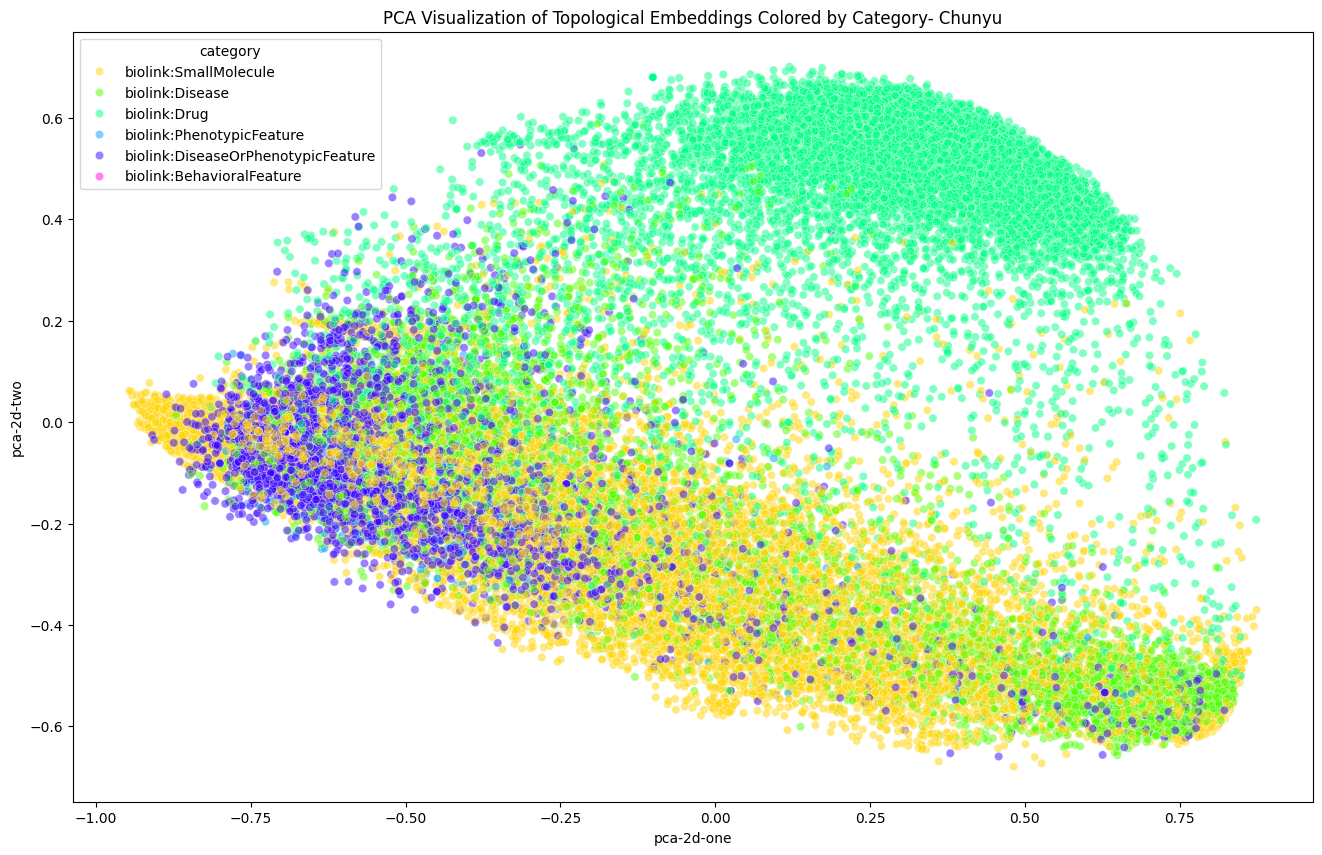

In [40]:
# Plot the result of PCA
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(final_df_chunyu['category'].unique())),
    data=final_df_chunyu,
    legend="full",
    alpha=0.5
)
plt.title('PCA Visualization of Topological Embeddings Colored by Category- Chunyu')

plt.savefig('../results/figures/PCA_Chunyu.png')

plt.show()
plt.close()

## Comparing the Embeddings

We compare the e2e and Chunyu's embeddings using various methods:

1. Cosine similarity
2. Distribution of individual embedding dimensions
3. Variance comparison
4. Correlation analysis

### Cosine Similarity

In [60]:
def generate_te_data(df1, df2):
    # Extract columns starting with 'TE' from both dataframes
    te_columns1 = [col for col in df1.columns if col.startswith('TE')]
    te_columns2 = [col for col in df2.columns if col.startswith('TE')]
    
    # Find common TE columns
    common_te_columns = list(set(te_columns1) & set(te_columns2))
    
    if not common_te_columns:
        raise ValueError("No common 'TE' columns found between the two dataframes")
    
    # Sort the common TE columns
    common_te_columns.sort(key=lambda x: int(x[2:]))  # Sort based on the number after 'TE'
    
    # Extract the TE data from both dataframes
    te_data1 = df1[common_te_columns]
    te_data2 = df2[common_te_columns]
    
    return te_data1, te_data2

In [61]:
te_data1, te_data2 = generate_te_data(subsampled_df, final_df_chunyu)

# Verify the column order
print("First few columns of te_data1:", te_data1.columns[:5].tolist())
print("First few columns of te_data2:", te_data2.columns[:5].tolist())
print("Last few columns of te_data1:", te_data1.columns[-5:].tolist())
print("Last few columns of te_data2:", te_data2.columns[-5:].tolist())

First few columns of te_data1: ['TE1', 'TE2', 'TE3', 'TE4', 'TE5']
First few columns of te_data2: ['TE1', 'TE2', 'TE3', 'TE4', 'TE5']
Last few columns of te_data1: ['TE508', 'TE509', 'TE510', 'TE511', 'TE512']
Last few columns of te_data2: ['TE508', 'TE509', 'TE510', 'TE511', 'TE512']


In [63]:
import seaborn as sns
import numpy as np

# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarities = np.diagonal(cosine_similarity(te_data1, te_data2))



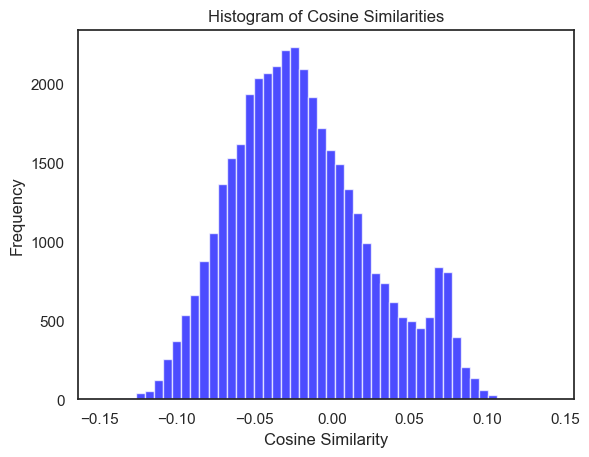

Mean Cosine Similarity: -0.019
Standard Deviation of Cosine Similarity: 0.045


In [64]:
import matplotlib.pyplot as plt

# Histogram of cosine similarities
plt.hist(similarities, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
mean_similarity = np.mean(similarities)
std_dev_similarity = np.std(similarities)

print(f"Mean Cosine Similarity: {mean_similarity:.3f}")
print(f"Standard Deviation of Cosine Similarity: {std_dev_similarity:.3f}")

plt.savefig('../results/figures/cosine_similarities_histogram.png')
plt.close()


There is very little similarity between the two sets of embeddings. 

### Distribution Comparison

In [66]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plot density of 'feature_x' from te_data
sns.kdeplot(te_data1['TE2'], label='EC TE 1', color="blue", fill=True, alpha=0.5)

# Plot density of 'feature_x' from te_data2
sns.kdeplot(te_data2['TE2'], label='tchunyu TE 1', color="red", fill=True, alpha=0.5)

# Add labels and title
plt.title('Density Plot of TE1 in EC and Chuny Data')

plt.savefig('../results/figures/density_plot_TE1.png')
plt.close()

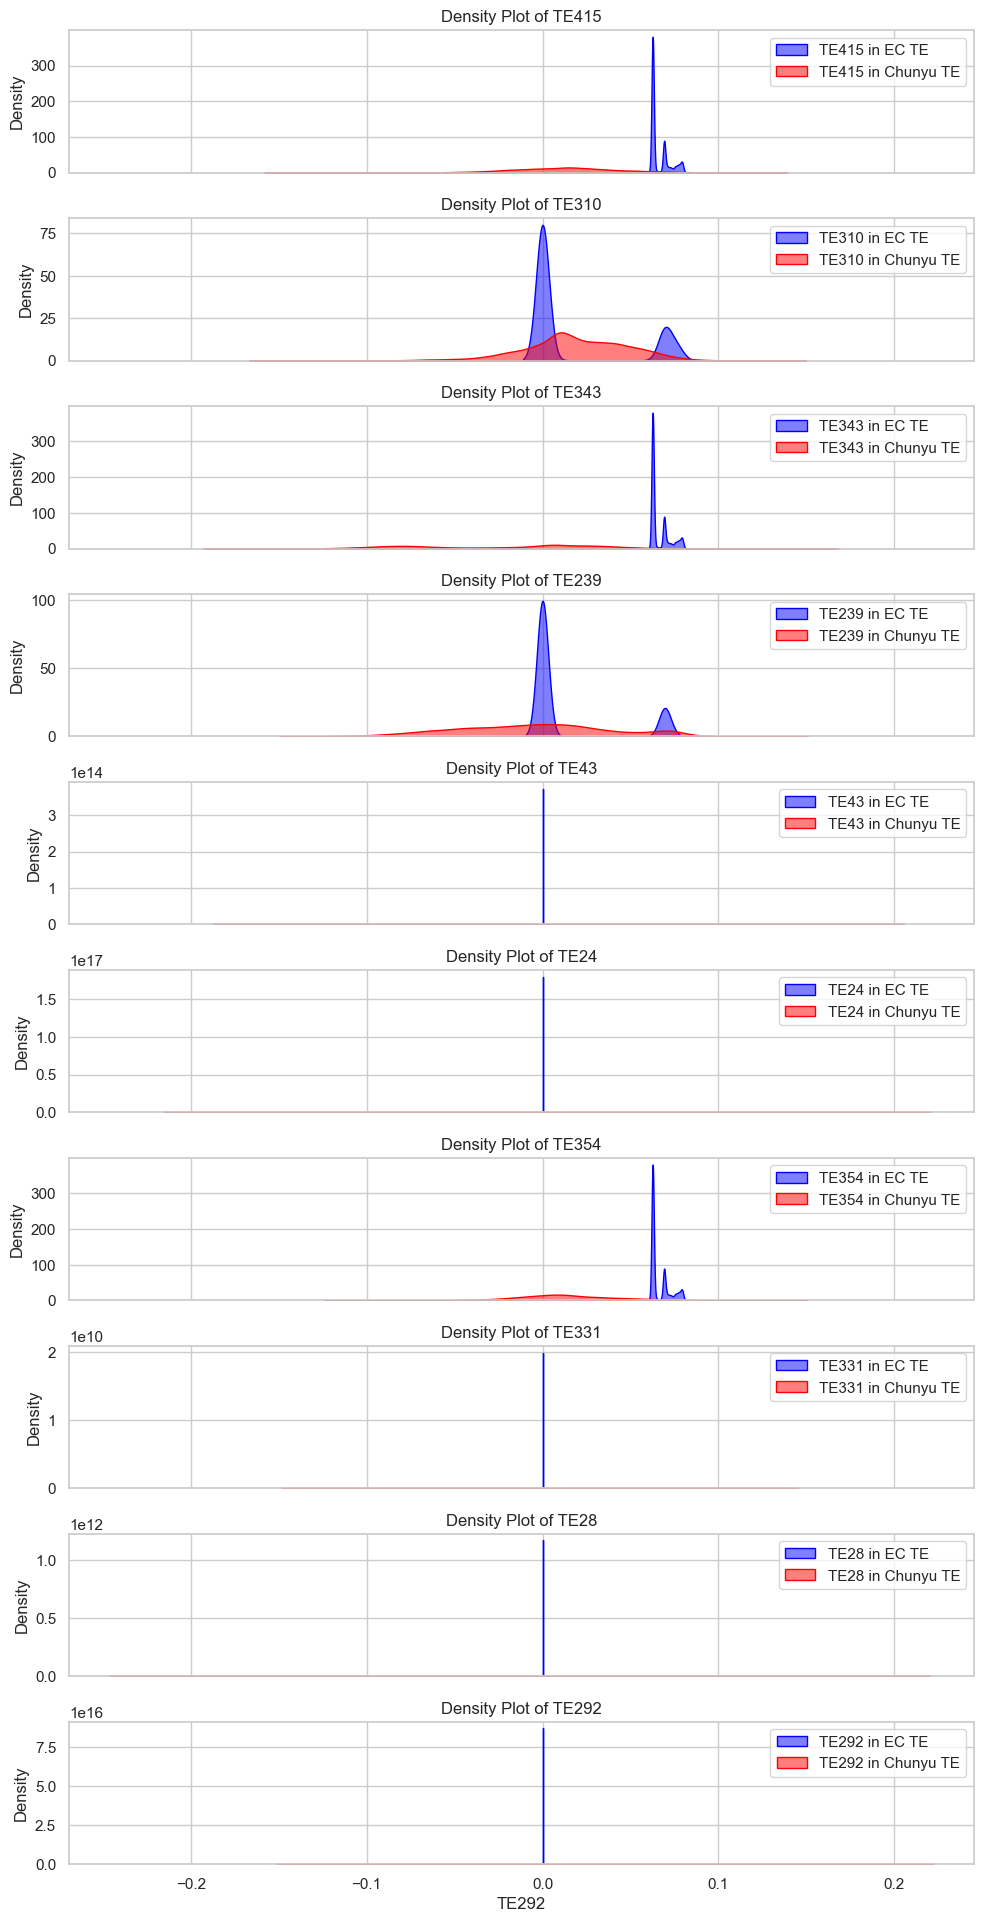

In [67]:
# compare several at onces
# Generate 10 random numbers between 1 and 512
import random

# Generate 10 random numbers between 1 and 512
random_numbers = [random.randint(1, 512) for _ in range(10)]

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20), sharex='col')

# Use the random indices to plot specific columns
for idx, ax in zip(random_numbers, axes):
    col_name = te_data1.columns[idx]  
    sns.kdeplot(te_data1[col_name], ax=ax, label=f'{col_name} in EC TE', color="blue", fill=True, alpha=0.5)
    sns.kdeplot(te_data2[col_name], ax=ax, label=f'{col_name} in Chunyu TE', color="red", fill=True, alpha=0.5)
    ax.set_title(f'Density Plot of {col_name}')
    ax.set_ylabel('Density')
    ax.legend()

# define plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

plt.savefig('../results/figures/density_plots_multiple_TEs.png')
plt.close()

EC embeddings appear to follow a distinct and repetetive pattern. 

### Variance Comparison

In [68]:
# Calculate variance for each column in te_data and te_data2
variances_te_data1 = te_data1.var()
variances_te_data2 = te_data2.var()

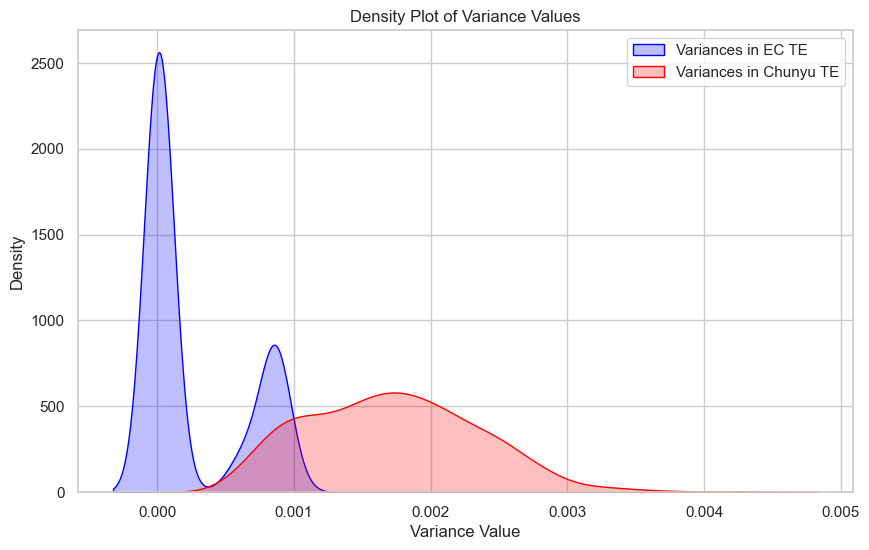

In [69]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plot density of variances for te_data
sns.kdeplot(variances_te_data1, label='Variances in EC TE', color="blue", fill=True)

# Plot density of variances for te_data2
sns.kdeplot(variances_te_data2, label='Variances in Chunyu TE', color="red", fill=True)

plt.title('Density Plot of Variance Values')
plt.xlabel('Variance Value')
plt.ylabel('Density')

plt.legend()

plt.show()

plt.savefig('../results/figures/variance_density_plot.png')
plt.close()

There is very little variance in the EC TE embeddings. 

### Correlation Analysis

In [70]:
# are the embeddings very similar across all dimensions? 

# Calculate the correlation matrix
correlation_matrix = te_data1.corr()
correlation_matrix2 = te_data2.corr()



In [71]:
# Create a mask (for visualization) with True where correlations are below 0.5 and above -0.5
mask = np.abs(correlation_matrix) <= 0.5
mask2 = np.abs(correlation_matrix2) <= 0.5

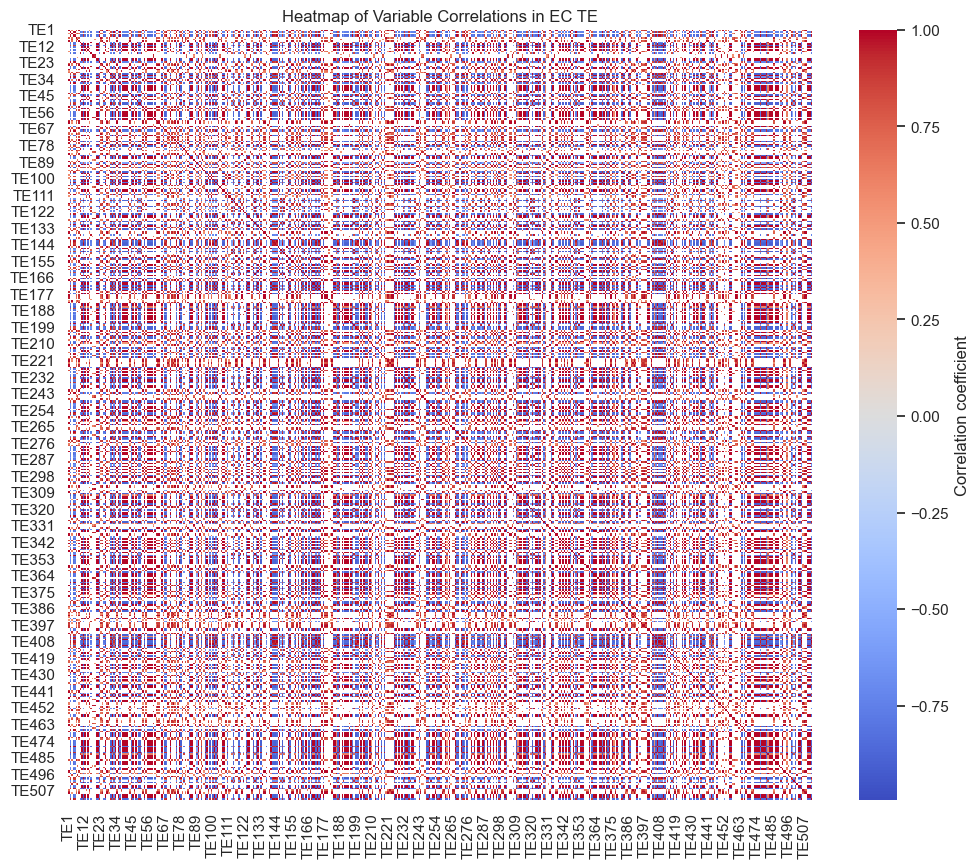

In [72]:
sns.set(style="white")

# Create a heatmap from the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Heatmap of Variable Correlations in EC TE')
plt.show()

plt.savefig('../results/figures/correlation_heatmap_EC_TE.png')
plt.close()

This shows the overall and strange pattern of the EC embeddings. They are either very similar or dissimilar to one another. 

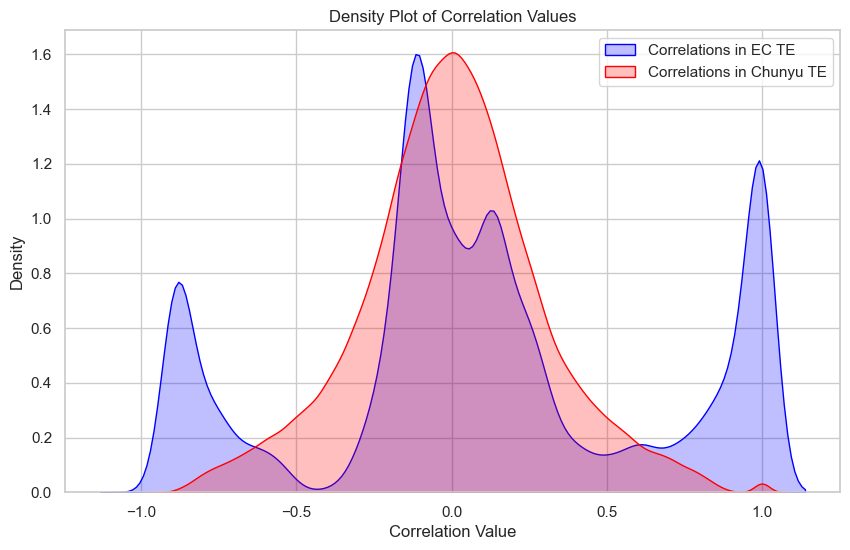

In [73]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plot density of variances for te_data
sns.kdeplot(correlation_matrix.values.flatten(), label='Correlations in EC TE', color="blue", fill=True)

# Plot density of variances for te_data2
sns.kdeplot(correlation_matrix2.values.flatten(), label='Correlations in Chunyu TE', color="red", fill=True)

plt.title('Density Plot of Correlation Values')
plt.xlabel('Correlation Value')
plt.ylabel('Density')

plt.legend()
plt.show()

plt.savefig('../results/figures/correlation_density_plot.png')
plt.close()

Again, high correlations between EC TE embeddings and the three pattenrs observed. 

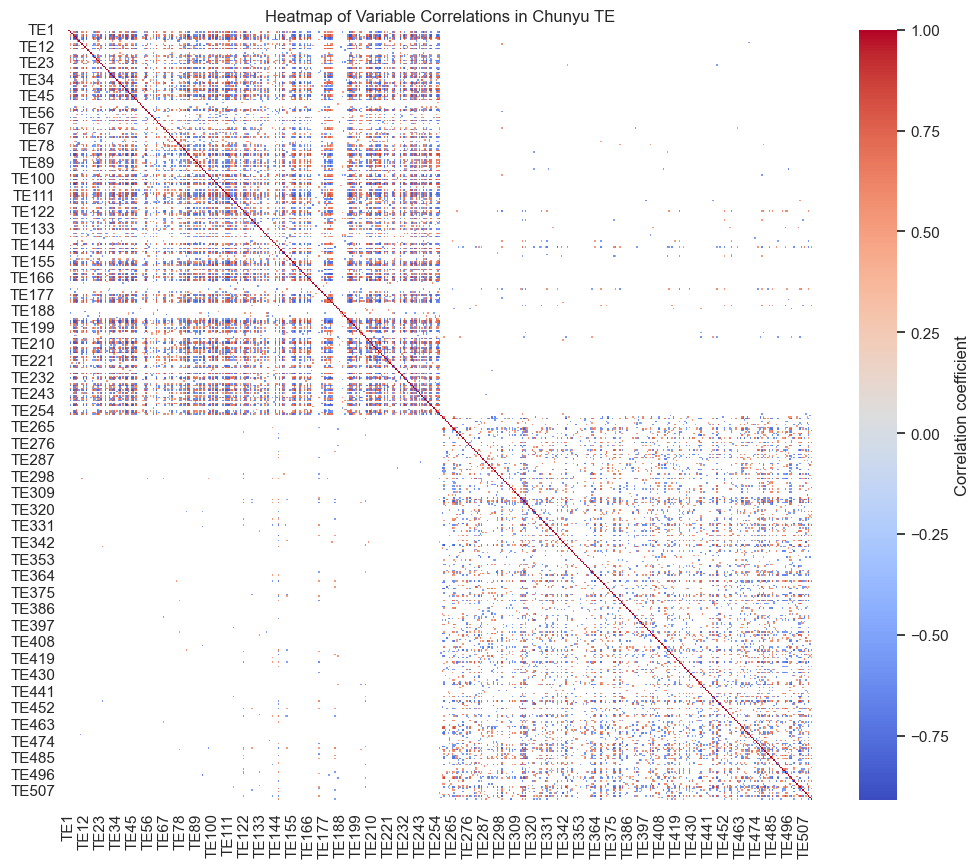

In [74]:
sns.set(style="white")

# Create a heatmap from the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, mask = mask2, annot=False, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Heatmap of Variable Correlations in Chunyu TE')
plt.show()

plt.savefig('../results/figures/correlation_heatmap_Chunyu_TE.png')
plt.close()

Chunyu's embeddings appear to group and are organized into a few distinct clusters. This is a strange observation which requires further investigation. Is this a consequence of the tokeninzation step, e.g. a lot of nodes are named with the same prefix? 

## Modeling

Run some predictions using the EC embeddings and compare to predictions using Chunyu's embeddings. 
We will use a simple random forest classifier to do this as an example. 



In [76]:
# From Alexei's notebook
# First step is to read in the treat, not-treat data and use these as our class labels. 

# Load in TN and TP dataset
tp_data = pd.read_csv('../data/raw/tp_pairs.txt', sep='\t', header=0)
tn_data = pd.read_csv('../data/raw/tn_pairs.txt', sep='\t', header=0)
# Add target column and concatenate
tp_data['y'] = 1; tn_data['y'] = 0

# Load knowledge graph node information
header = pd.read_csv('../data/raw/nodes_c_header.tsv', delimiter='\t', header=None).iloc[0]
node_df = pd.read_csv('../data/raw/nodes_c.tsv', delimiter='\t', names=header, dtype='unicode')

In [79]:

from sklearn.model_selection import train_test_split

# Test-train splits for TP + TN dataset
tptn_df = pd.concat([tp_data, tn_data])
train_tptn_df, test_tptn_df = train_test_split(tptn_df, test_size=0.1, random_state=42)

## Data Preparation Functions

The following functions are used to prepare our data for the random forest classifier. They extract embeddings and create vectorized datasets.

In [93]:
def get_embedding(id, embedding_df):
    # Get the row for the given id
    row = embedding_df[embedding_df['id'] == id]
    
    if row.empty:
        raise ValueError(f"No embedding found for id: {id}")
    
    # Select only the columns that start with 'TE'
    te_columns = [col for col in embedding_df.columns if col.startswith('TE')]
    
    # Sort the TE columns to ensure correct order
    te_columns.sort(key=lambda x: int(x[2:]))
    
    # Return the flattened array of TE values
    return row[te_columns].values.flatten()



In [96]:
# Test the function
test_id = subsampled_df['id'].iloc[0]  # Get the first id as a test
test_embedding = get_embedding(test_id, subsampled_df)

print(f"Embedding for id {test_id}:")
print(f"Number of features: {len(test_embedding)}")
print(f"First 5 values: {test_embedding[:5]}")
print(f"Last 5 values: {test_embedding[-5:]}")

Embedding for id NBO:0000243:
Number of features: 512
First 5 values: [3.36019938e-24 4.46283259e-43 3.11462620e-22 9.73966383e-45
 2.38311186e-40]
Last 5 values: [1.13483378e-24 6.90164426e-02 6.90164426e-02 6.90164426e-02
 1.75070987e-47]


In [98]:
import numpy as np
import pandas as pd

def give_vectorised_dataset(df, embedding_df):
    # Get unique IDs from source and target columns
    unique_ids = set(df['source'].unique()) | set(df['target'].unique())
    
    # Subset embedding_df to only include relevant IDs
    relevant_embeddings = embedding_df[embedding_df['id'].isin(unique_ids)]
    
    # Create a dictionary for quick lookup
    embedding_dict = {row['id']: row.filter(like='TE').values for _, row in relevant_embeddings.iterrows()}
    
    # Get the number of TE columns
    n_features = len([col for col in relevant_embeddings.columns if col.startswith('TE')])
    
    X = []
    y = []
    found_count = 0
    total_count = len(df)
    
    for _, row in df.iterrows():
        source_id = row['source']
        target_id = row['target']
        
        if source_id in embedding_dict and target_id in embedding_dict:
            drug_vector = embedding_dict[source_id]
            disease_vector = embedding_dict[target_id]
            X.append(np.concatenate([drug_vector, disease_vector]))
            y.append(row['y'])
            found_count += 1
    
    X = np.array(X, dtype='float32')
    y = np.array(y)
    
    print(f"Processed {found_count} out of {total_count} entries.")
    print(f"Skipped {total_count - found_count} entries due to missing embeddings.")
    
    return X, y, found_count



In [ ]:
# Use the function
X_test, y_test, found_count = give_vectorised_dataset(test_tptn_df, subsampled_df)

print(f"Shape of X: {X_test.shape}")
print(f"Shape of y: {y_test.shape}")
print(f"Total valid entries: {found_count}")

In [106]:
train_tptn_df

source         target  y
8489   CHEMBL.COMPOUND:CHEMBL1201589  MONDO:0019945  1
4153   CHEMBL.COMPOUND:CHEMBL1905872  MONDO:0006665  0
14861                  RXNORM:203279  MONDO:0011728  1
6939   CHEMBL.COMPOUND:CHEMBL1200881  MONDO:0010383  1
25668  CHEMBL.COMPOUND:CHEMBL1889140  MONDO:0004568  0
...                              ...            ... ..
23295      CHEMBL.COMPOUND:CHEMBL163  MONDO:0012819  0
32906  CHEMBL.COMPOUND:CHEMBL1201566  MONDO:0005233  0
16721     CHEMBL.COMPOUND:CHEMBL1511  MONDO:0013775  0
860        CHEMBL.COMPOUND:CHEMBL635  MONDO:0012959  1
15795  CHEMBL.COMPOUND:CHEMBL1200382  MONDO:0004981  1

[49163 rows x 3 columns]

## Random Forest Classifier Building and Evaluation

This function builds a random forest classifier using grid search for hyperparameter tuning, 
trains it on the provided data, and evaluates its performance.

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def build_and_evaluate_rf_classifier(X_train, y_train, X_test, y_test):
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create a base model
    rf = RandomForestClassifier(random_state=42)

    # Instantiate the grid search model
    print("Performing grid search...")
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_rf = grid_search.best_estimator_

    # Make predictions on the test set
    print("Making predictions...")
    y_pred = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Print results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return best_rf, (y_test, y_pred, y_pred_proba)


## Feature Importance Analysis

This function analyzes and visualizes the feature importance of the trained random forest model.

In [115]:
def analyze_feature_importance(best_rf):
    feature_importance = best_rf.feature_importances_
    feature_names = [f"Feature_{i}" for i in range(len(feature_importance))]
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False).head(20)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('../results/figures/feature_importance_rf.png')
    plt.show()

    return importance_df


## Run and Compare


In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to process data and train model for a given embedding
def process_and_evaluate(train_tptn_df, test_tptn_df, embedding_df, name):
    print(f"\nProcessing {name} embeddings...")
    
    # Prepare training data
    X_train, y_train, train_count = give_vectorised_dataset(train_tptn_df, embedding_df)
    print(f"Training data: processed {train_count} out of {len(train_tptn_df)} entries.")
    
    # Prepare test data
    X_test, y_test, test_count = give_vectorised_dataset(test_tptn_df, embedding_df)
    print(f"Test data: processed {test_count} out of {len(test_tptn_df)} entries.")
    
    # Train and evaluate model
    best_rf, (y_test, y_pred, y_pred_proba) = build_and_evaluate_rf_classifier(X_train, y_train, X_test, y_test)
    
    # Analyze feature importance
    feature_importance = analyze_feature_importance(best_rf)
    feature_importance.to_csv(f'../results/feature_importance_rf_{name.lower()}.csv', index=False)
    
    return best_rf, X_test, y_test, y_pred, y_pred_proba, feature_importance



In [144]:
# Process both e2e and Chunyu embeddings
import pickle
import os

def load_or_process_embeddings(train_tptn_df, test_tptn_df, embedding_dfs):
    results_path = '../results/rf_results.pkl'
    
    if os.path.exists(results_path):
        print("Loading existing results...")
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
    else:
        print("Processing embeddings and evaluating models...")
        results = {}
        for name, embedding_df in embedding_dfs.items():
            print(f"\nProcessing {name} embeddings...")
            results[name] = process_and_evaluate(train_tptn_df, test_tptn_df, embedding_df, name)
        
        # Save the results
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to {results_path}")
    
    return results




In [145]:
embedding_dfs = {
    "E2E": final_df,
    "Chunyu": raw_df_chunyu
}

results = load_or_process_embeddings(train_tptn_df, test_tptn_df, embedding_dfs)

# Now you can use the results for further analysis or visualization
for name, result in results.items():
    print(f"\nResults for {name} embeddings:")
    best_rf, X_test, y_test, y_pred, y_pred_proba, feature_importance = result
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    # Add any other metrics or analyses you want to perform


Loading existing results...

Results for E2E embeddings:
Accuracy: 0.7000
AUC-ROC: 0.6613

Results for Chunyu embeddings:
Accuracy: 0.9195
AUC-ROC: 0.9737


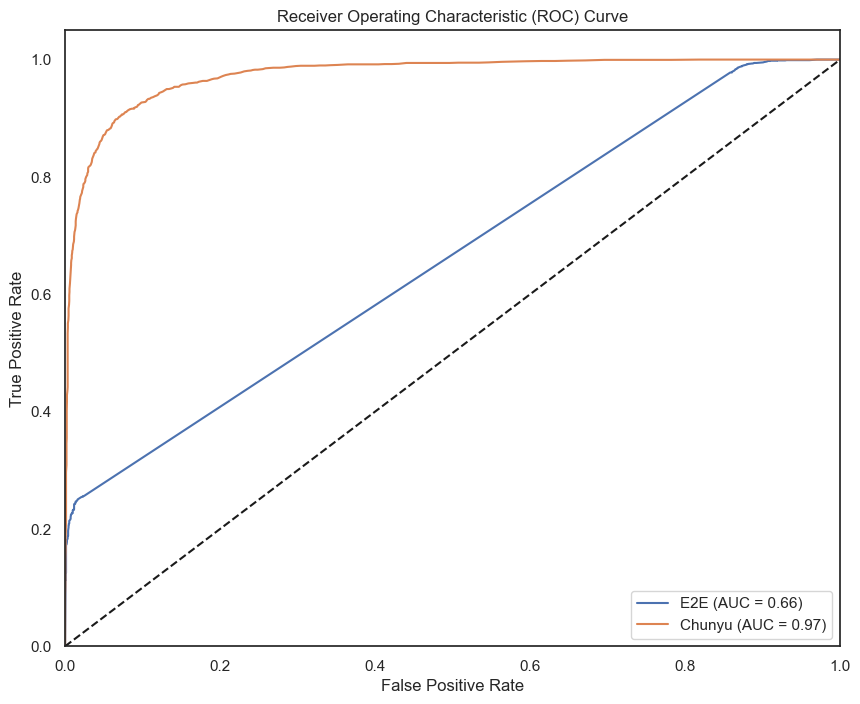

In [146]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
for name, (_, _, y_test, _, y_pred_proba, _) in results.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('../results/figures/roc_curve_comparison.png')
plt.show()



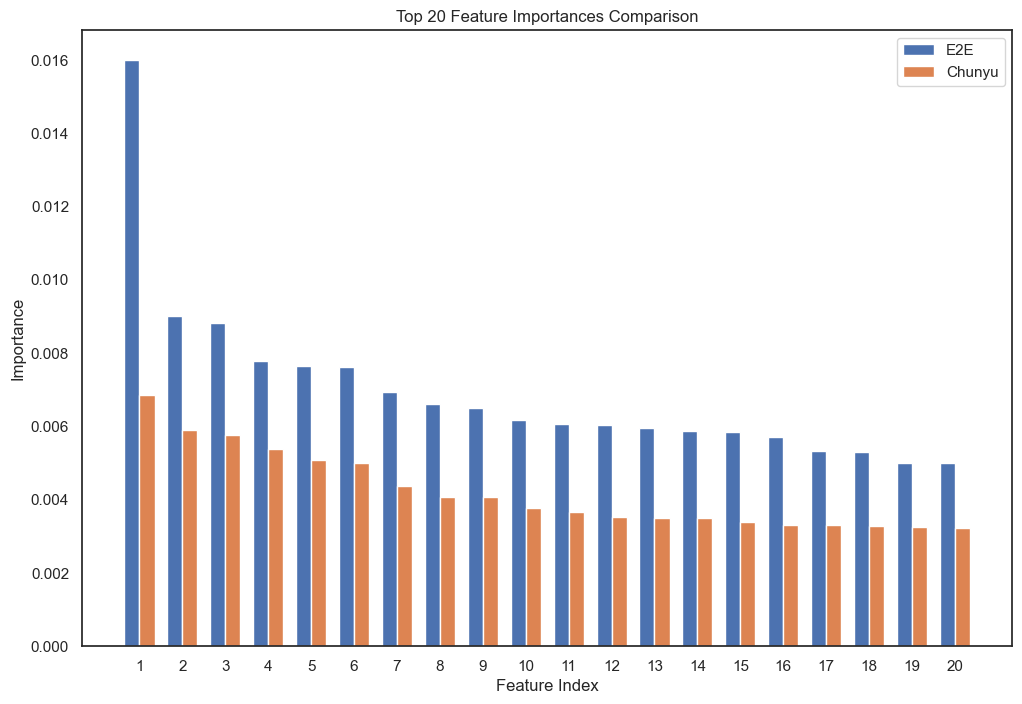

In [147]:
# Compare feature importances
plt.figure(figsize=(12, 8))
width = 0.35
x = np.arange(20)

for i, (name, (_, _, _, _, _, feature_importance)) in enumerate(results.items()):
    importance = feature_importance['importance'][:20]
    plt.bar(x + i*width, importance, width, label=name)

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances Comparison')
plt.xticks(x + width/2, range(1, 21))
plt.legend()
plt.savefig('../results/figures/feature_importance_comparison.png')
plt.show()



In [148]:
# Print summary of results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for name, (_, _, y_test, y_pred, y_pred_proba, _) in results.items():
    print(f"\nResults for {name} embeddings:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Results for E2E embeddings:
Accuracy: 0.7000
Precision: 0.9264
Recall: 0.2348
F1 Score: 0.3747
AUC-ROC: 0.6613

Results for Chunyu embeddings:
Accuracy: 0.9195
Precision: 0.9061
Recall: 0.8809
F1 Score: 0.8933
AUC-ROC: 0.9737


## Conclusion 

Explore the Neo4J implementation of GraphSage to ensure that it is behaving as it should to more closely replicate Chunyu's work. This should involve a certain amount of hyperparameter tuning. 